In [3]:
import numpy as np
from matplotlib import pyplot as plt
import torch
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
from preprocessing import EcgDataset, ToTensor

transform = transforms.Compose([ToTensor(),
                                transforms.Resize([64,64])])

dataset = EcgDataset(
    root_dir="Data/training_data/dataset",
    transform=transform
)

train_data, val_data = random_split(dataset, [0.8,0.2])

train_loader = DataLoader(
    train_data,
    batch_size=64,
    shuffle=True
)
val_loader = DataLoader(
    val_data,
    batch_size=64,
    shuffle=True
)

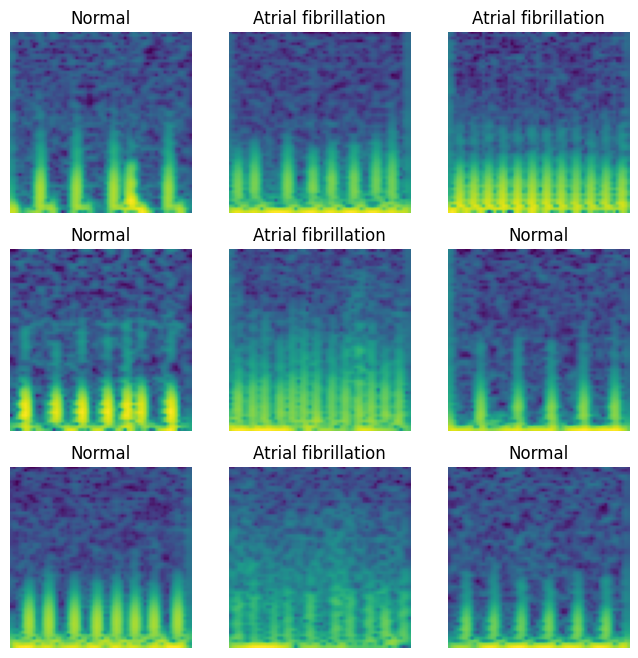

In [4]:
labels_map = {
    0: "Normal",
    1: "Atrial fibrillation"
}

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    # print(sample_idx)
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="viridis")
plt.show()

In [ ]:
import torch.nn as nn
from torchsummary import summary

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(), #TODO: Dimensions
            nn.ReLU(),
            nn.MaxPool2d() #TODO: Dimensions
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(), #TODO: Dimensions
            nn.ReLU(),
            nn.MaxPool2d() #TODO: Dimensions
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(), #TODO: Dimensions
            nn.ReLU(),
            nn.MaxPool2d() #TODO: Dimensions
        )

        self.dropout = nn.Dropout(0.25)
        
        self.dense1 = nn.Sequential(
            nn.Linear(), #TODO: Dimensions
            nn.ReLU()
        )
        
        self.dense2 = nn.Sequential(
            nn.Linear(), #TODO: Dimensions
            nn.Softmax() #TODO: Verify
        )
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)

        # Flatten
        x = x.view(x.size(0), -1)

        x = self.dropout(x)
        x = self.dense1(x)
        x = self.dense2(x)

        return x
    
net = Net()
if torch.cuda.is_available():
    net.cuda()

summary(net, ()) #TODO: